# 6.1. Модель ARIMA

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [2]:
import os
import numpy
import scipy
from pandas import read_csv
from pandas.plotting import lag_plot
from pandas import DataFrame
from pandas import concat
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.ar_model import AutoReg
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
import warnings
from math import sqrt
from statsmodels.tsa.ar_model import AutoRegResults
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error 
import math

In [3]:
os.chdir("C:/Users/HP/Documents/analysis/TS/data/")

# Autoregression Models for Forecasting

Авторегрессия - это модель временных рядов, в которой в качестве входных данных для уравнения регрессии используются наблюдения за предыдущие временные шаги, чтобы предсказать значение на следующем временном шаге. Это может выглядеть следующим образом:
* X(t + 1) = b0 + (b1 * X(t)) + (b2 * X(t - 1))

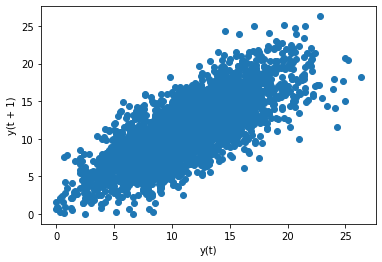

In [4]:
# lag plot of time series
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
lag_plot(series)
pyplot.show()

In [5]:
# correlation of lag=1
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
result = dataframe.corr()
print(result)

           t      t+1
t    1.00000  0.77487
t+1  0.77487  1.00000


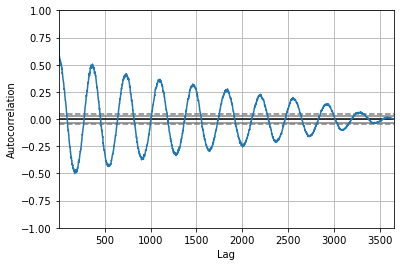

In [6]:
# autocorrelation plot of time series
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
autocorrelation_plot(series)
pyplot.show()

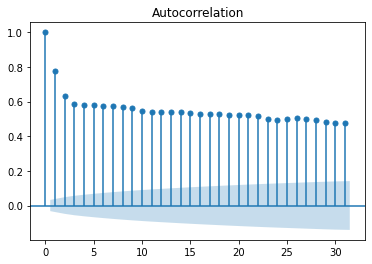

In [7]:
# autocorrelation plot of time series
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
plot_acf(series, lags=31)
pyplot.show()

Test RMSE: 1.850


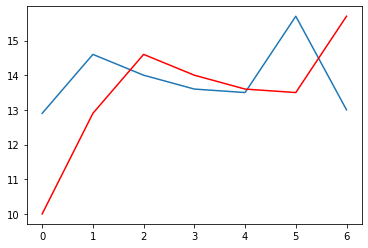

In [8]:
# evaluate a persistence model
# load dataset
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model
def model_persistence(x):
	return x
# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

Coefficients: [ 5.57543506e-01  5.88595221e-01 -9.08257090e-02  4.82615092e-02
  4.00650265e-02  3.93020055e-02  2.59463738e-02  4.46675960e-02
  1.27681498e-02  3.74362239e-02 -8.11700276e-04  4.79081949e-03
  1.84731397e-02  2.68908418e-02  5.75906178e-04  2.48096415e-02
  7.40316579e-03  9.91622149e-03  3.41599123e-02 -9.11961877e-03
  2.42127561e-02  1.87870751e-02  1.21841870e-02 -1.85534575e-02
 -1.77162867e-03  1.67319894e-02  1.97615668e-02  9.83245087e-03
  6.22710723e-03 -1.37732255e-03]
predicted=11.871275, expected=12.900000
predicted=13.053794, expected=14.600000
predicted=13.532591, expected=14.000000
predicted=13.243126, expected=13.600000
predicted=13.091438, expected=13.500000
predicted=13.146989, expected=15.700000
predicted=13.176153, expected=13.000000
Test RMSE: 1.225


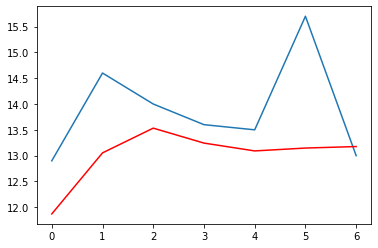

In [9]:
# create and evaluate a static autoregressive model
# load dataset
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AutoReg(train, lags=29,old_names=False)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

predicted=11.871275, expected=12.900000
predicted=13.659297, expected=14.600000
predicted=14.349246, expected=14.000000
predicted=13.427454, expected=13.600000
predicted=13.374877, expected=13.500000
predicted=13.479991, expected=15.700000
predicted=14.765146, expected=13.000000
Test RMSE: 1.204


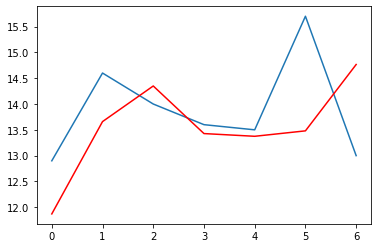

In [10]:
# create and evaluate an updated autoregressive model
# load dataset
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
window = 29
model = AutoReg(train, lags=29,old_names=False)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

# Moving Average Models for Forecasting

In [11]:
# calculate residual errors for a persistence forecast model
# load data
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model
predictions = [x for x in test_X]
# skill of persistence model
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)
# calculate residuals
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = DataFrame(residuals)
print(residuals.head())

Test RMSE: 9.151
      0
0   9.0
1 -10.0
2   3.0
3  -6.0
4  30.0


In [12]:
# autoregressive model of residual errors
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model on training set
train_pred = [x for x in train_X]
# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]
# model the training set residuals
model = AutoReg(train_resid, lags=15,old_names=False)
model_fit = model.fit()
print('Coef=%s' % (model_fit.params))

Coef=[ 0.10120699 -0.84940615 -0.77783609 -0.73345006 -0.68902061 -0.59270551
 -0.5376728  -0.42553356 -0.24861246 -0.19972102 -0.15954013 -0.11045476
 -0.14045572 -0.13299964 -0.12515801 -0.03615774]


predicted error=1.155523, expected error=9.000000
predicted error=-7.108809, expected error=-10.000000
predicted error=3.007486, expected error=3.000000
predicted error=-0.756446, expected error=-6.000000
predicted error=5.511163, expected error=30.000000
predicted error=-19.991264, expected error=-28.000000
predicted error=4.842429, expected error=2.000000
predicted error=3.050883, expected error=9.000000
predicted error=-5.141585, expected error=-7.000000
predicted error=1.161119, expected error=1.000000
predicted error=-0.241928, expected error=-9.000000
predicted error=9.159826, expected error=21.000000
predicted error=-7.117974, expected error=-13.000000
predicted error=1.182992, expected error=-2.000000
predicted error=2.769363, expected error=11.000000
predicted error=-4.959337, expected error=-11.000000
predicted error=2.566233, expected error=-8.000000
predicted error=9.084498, expected error=6.000000
predicted error=3.020899, expected error=16.000000
predicted error=-6.542098

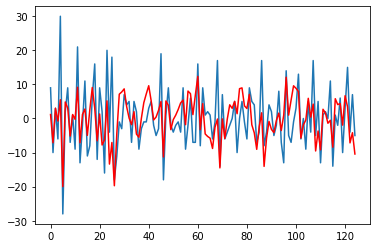

In [13]:
# forecast residual forecast error
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model on training set
train_pred = [x for x in train_X]
# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]
# model the training set residuals
window = 15
model = AutoReg(train_resid, lags=window,old_names=False)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
expected_error = list()
for t in range(len(test_y)):
	# persistence
	yhat = test_X[t]
	error = test_y[t] - yhat
	expected_error.append(error)
	# predict error
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	pred_error = coef[0]
	for d in range(window):
		pred_error += coef[d+1] * lag[window-d-1]
	predictions.append(pred_error)
	history.append(error)
	print('predicted error=%f, expected error=%f' % (pred_error, error))
# plot predicted error
pyplot.plot(expected_error)
pyplot.plot(predictions, color='red')
pyplot.show()

predicted=43.155523, expected=51.000000
predicted=43.891191, expected=41.000000
predicted=44.007486, expected=44.000000
predicted=43.243554, expected=38.000000
predicted=43.511163, expected=68.000000
predicted=48.008736, expected=40.000000
predicted=44.842429, expected=42.000000
predicted=45.050883, expected=51.000000
predicted=45.858415, expected=44.000000
predicted=45.161119, expected=45.000000
predicted=44.758072, expected=36.000000
predicted=45.159826, expected=57.000000
predicted=49.882026, expected=44.000000
predicted=45.182992, expected=42.000000
predicted=44.769363, expected=53.000000
predicted=48.040663, expected=42.000000
predicted=44.566233, expected=34.000000
predicted=43.084498, expected=40.000000
predicted=43.020899, expected=56.000000
predicted=49.457902, expected=44.000000
predicted=45.328116, expected=53.000000
predicted=45.225588, expected=55.000000
predicted=48.705924, expected=39.000000
predicted=44.166344, expected=59.000000
predicted=45.621871, expected=55.000000


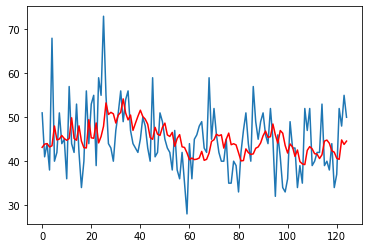

In [14]:
# correct forecasts with a model of forecast residual errors
# load data
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model on training set
train_pred = [x for x in train_X]
# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]
# model the training set residuals
window = 15
model = AutoReg(train_resid, lags=15,old_names=False)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test_y)):
	# persistence
	yhat = test_X[t]
	error = test_y[t] - yhat
	# predict error
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	pred_error = coef[0]
	for d in range(window):
		pred_error += coef[d+1] * lag[window-d-1]
	# correct the prediction
	yhat = yhat + pred_error
	predictions.append(yhat)
	history.append(error)
	print('predicted=%f, expected=%f' % (yhat, test_y[t]))
# error
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)
# plot predicted error
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

# ARIMA Model for Forecasting

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


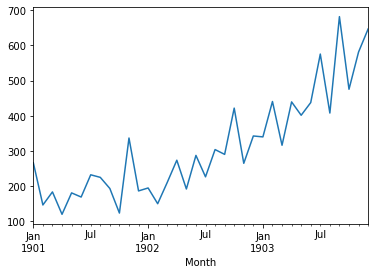

In [15]:
# load and plot dataset
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
# summarize first few rows
print(series.head())
# line plot
series.plot()
pyplot.show()

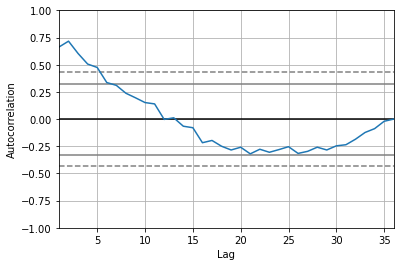

In [16]:
# autocorrelation plot of time series
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
# autocorrelation plot
autocorrelation_plot(series)
pyplot.show()

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -198.485
Date:                Thu, 27 Jan 2022   AIC                            408.969
Time:                        15:53:02   BIC                            418.301
Sample:                    01-01-1901   HQIC                           412.191
                         - 12-01-1903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9014      0.247     -3.647      0.000      -1.386      -0.417
ar.L2         -0.2284      0.268     -0.851      0.395      -0.754       0.298
ar.L3          0.0747      0.291      0.256      0.7

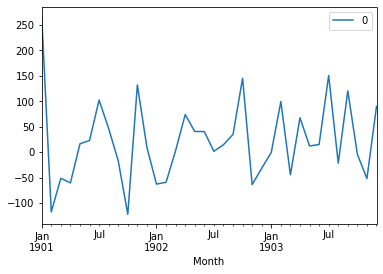

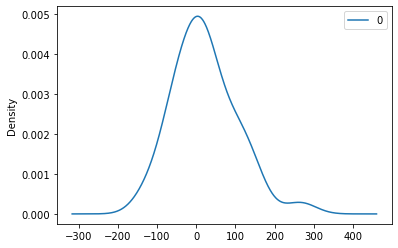

                0
count   36.000000
mean    21.936144
std     80.774430
min   -122.292030
25%    -35.040859
50%     13.147219
75%     68.848286
max    266.000000


In [20]:
# fit an ARIMA model and plot residual errors
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
# fit model
series.index.freq = series.index.inferred_freq
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

predicted=343.272180, expected=342.300000
predicted=293.329674, expected=339.700000
predicted=368.668956, expected=440.400000
predicted=335.044741, expected=315.900000
predicted=363.220221, expected=439.300000
predicted=357.645324, expected=401.300000
predicted=443.047835, expected=437.400000
predicted=378.365673, expected=575.500000
predicted=459.415021, expected=407.600000
predicted=526.890876, expected=682.000000
predicted=457.231275, expected=475.300000
predicted=672.914944, expected=581.300000
predicted=531.541449, expected=646.900000
Test RMSE: 89.021


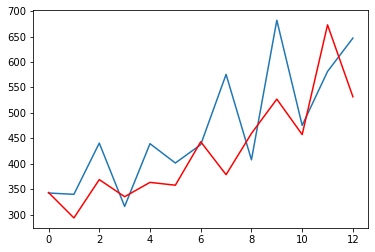

In [22]:
# evaluate an ARIMA model using a walk-forward validation
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

# Autocorrelation and Partial Autocorrelation

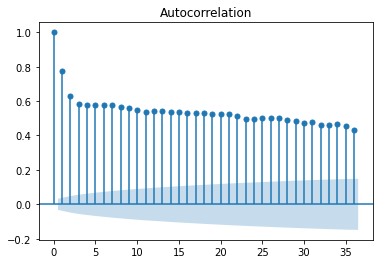

In [23]:
# ACF plot of time series
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
plot_acf(series)
pyplot.show()

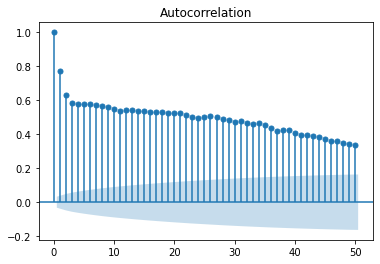

In [24]:
# zoomed-in ACF plot of time series
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
plot_acf(series, lags=50)
pyplot.show()

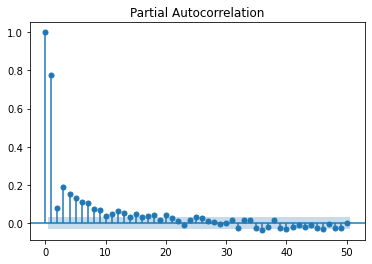

In [25]:
# PACF plot of time series
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
plot_pacf(series, lags=50)
pyplot.show()

# Grid Search ARIMA Model Hyperparameters

In [26]:
# grid search ARIMA parameters for time series
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=228.966
ARIMA(0, 0, 1) RMSE=195.596
ARIMA(0, 0, 2) RMSE=154.886
ARIMA(0, 1, 0) RMSE=133.156
ARIMA(0, 1, 1) RMSE=104.077
ARIMA(0, 1, 2) RMSE=68.345
ARIMA(0, 2, 0) RMSE=255.187
ARIMA(0, 2, 1) RMSE=134.168
ARIMA(0, 2, 2) RMSE=74.644
ARIMA(1, 0, 0) RMSE=152.028
ARIMA(1, 0, 1) RMSE=111.787
ARIMA(1, 0, 2) RMSE=77.086
ARIMA(1, 1, 0) RMSE=88.631
ARIMA(1, 1, 1) RMSE=87.942
ARIMA(1, 1, 2) RMSE=90.986
ARIMA(1, 2, 0) RMSE=134.576
ARIMA(1, 2, 1) RMSE=86.157
ARIMA(1, 2, 2) RMSE=65.511
ARIMA(2, 0, 0) RMSE=100.879
ARIMA(2, 0, 1) RMSE=98.953
ARIMA(2, 0, 2) RMSE=98.688
ARIMA(2, 1, 0) RMSE=85.063
ARIMA(2, 1, 1) RMSE=88.428
ARIMA(2, 1, 2) RMSE=83.497
ARIMA(2, 2, 0) RMSE=97.829
ARIMA(2, 2, 1) RMSE=76.847
ARIMA(2, 2, 2) RMSE=80.807
ARIMA(4, 0, 0) RMSE=100.974
ARIMA(4, 0, 1) RMSE=101.511
ARIMA(4, 0, 2) RMSE=97.686
ARIMA(4, 1, 0) RMSE=95.068
ARIMA(4, 1, 1) RMSE=84.816
ARIMA(4, 1, 2) RMSE=84.204
ARIMA(4, 2, 0) RMSE=85.397
ARIMA(4, 2, 1) RMSE=74.219
ARIMA(4, 2, 2) RMSE=70.140
ARIMA(6, 0, 0) 

In [27]:
# grid search ARIMA parameters for time series
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=8.189
ARIMA(0, 0, 1) RMSE=7.884
ARIMA(0, 0, 2) RMSE=7.771
ARIMA(0, 1, 0) RMSE=9.151
ARIMA(0, 1, 1) RMSE=7.427
ARIMA(0, 1, 2) RMSE=7.352
ARIMA(0, 2, 0) RMSE=15.670
ARIMA(0, 2, 1) RMSE=9.167
ARIMA(0, 2, 2) RMSE=7.455
ARIMA(1, 0, 0) RMSE=7.802
ARIMA(1, 0, 1) RMSE=7.568
ARIMA(1, 0, 2) RMSE=7.551
ARIMA(1, 1, 0) RMSE=8.106
ARIMA(1, 1, 1) RMSE=7.340
ARIMA(1, 1, 2) RMSE=7.329
ARIMA(1, 2, 0) RMSE=11.968
ARIMA(1, 2, 1) RMSE=8.120
ARIMA(1, 2, 2) RMSE=7.408
ARIMA(2, 0, 0) RMSE=7.697
ARIMA(2, 0, 1) RMSE=7.538
ARIMA(2, 1, 0) RMSE=7.700
ARIMA(2, 1, 1) RMSE=7.332
ARIMA(2, 1, 2) RMSE=7.355
ARIMA(2, 2, 0) RMSE=10.355
ARIMA(2, 2, 1) RMSE=7.714
ARIMA(4, 0, 0) RMSE=7.693
ARIMA(4, 0, 1) RMSE=7.505
ARIMA(4, 1, 0) RMSE=7.565
ARIMA(4, 1, 1) RMSE=7.396
ARIMA(4, 1, 2) RMSE=7.321
ARIMA(4, 2, 0) RMSE=8.940
ARIMA(4, 2, 1) RMSE=7.577
ARIMA(6, 0, 0) RMSE=7.666
ARIMA(6, 0, 1) RMSE=8.792
ARIMA(6, 1, 0) RMSE=7.281
ARIMA(6, 1, 1) RMSE=7.340
ARIMA(6, 1, 2) RMSE=7.432
ARIMA(6, 2, 0) RMSE=8.337
ARIMA(6, 

# Save Models and Make Predictions

Test RMSE: 7.259


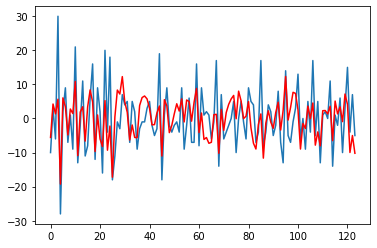

In [28]:
# fit and evaluate an AR model
# create a difference transform of the dataset
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return numpy.array(diff)

# Make a prediction give regression coefficients and lag obs
def predict(coef, history):
	yhat = coef[0]
	for i in range(1, len(coef)):
		yhat += coef[i] * history[-i]
	return yhat

series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# split dataset
X = difference(series.values)
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:]
# train autoregression
window = 6
model = AutoReg(train, lags=6)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = [train[i] for i in range(len(train))]
predictions = list()
for t in range(len(test)):
	yhat = predict(coef, history)
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [29]:
# fit an AR model and save the whole model to file
# create a difference transform of the dataset
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return numpy.array(diff)

# load dataset
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
X = difference(series.values)
# fit model
model = AutoReg(X, lags=6)
model_fit = model.fit()
# save model to file
model_fit.save('ar_model.pkl')
# save the differenced dataset
numpy.save('ar_data.npy', X)
# save the last ob
numpy.save('ar_obs.npy', [series.values[-1]])

In [30]:
# load the AR model from file
loaded = AutoRegResults.load('ar_model.pkl')
print(loaded.params)
data = numpy.load('ar_data.npy')
last_ob = numpy.load('ar_obs.npy')
print(last_ob)

[ 0.12129822 -0.75275857 -0.612367   -0.51097172 -0.4176669  -0.32116469
 -0.23412997]
[50]


In [31]:
# fit an AR model and manually save coefficients to file
# create a difference transform of the dataset
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return numpy.array(diff)

# load dataset
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
X = difference(series.values)
# fit model
window_size = 6
model = AutoReg(X, lags=window_size)
model_fit = model.fit()
# save coefficients
coef = model_fit.params
numpy.save('man_model.npy', coef)
# save lag
lag = X[-window_size:]
numpy.save('man_data.npy', lag)
# save the last ob
numpy.save('man_obs.npy', [series.values[-1]])

In [32]:
# load the manually saved model from file
coef = numpy.load('man_model.npy')
print(coef)
lag = numpy.load('man_data.npy')
print(lag)
last_ob = numpy.load('man_obs.npy')
print(last_ob)

[ 0.12129822 -0.75275857 -0.612367   -0.51097172 -0.4176669  -0.32116469
 -0.23412997]
[-10   3  15  -4   7  -5]
[50]


In [33]:
# load AR model from file and make a one-step prediction
# load model
model = AutoRegResults.load('ar_model.pkl')
data = numpy.load('ar_data.npy')
last_ob = numpy.load('ar_obs.npy')
# make prediction
predictions = model.predict(start=len(data), end=len(data))
# transform prediction
yhat = predictions[0] + last_ob[0]
print('Prediction: %f' % yhat)

Prediction: 46.755211


In [34]:
# load a coefficients and from file and make a manual prediction
def predict(coef, history):
	yhat = coef[0]
	for i in range(1, len(coef)):
		yhat += coef[i] * history[-i]
	return yhat

# load model
coef = numpy.load('man_model.npy')
lag = numpy.load('man_data.npy')
last_ob = numpy.load('man_obs.npy')
# make prediction
prediction = predict(coef, lag)
# transform prediction
yhat = prediction + last_ob[0]
print('Prediction: %f' % yhat)

Prediction: 46.755211


In [35]:
# update the data for the AR model with a new obs
# get real observation
observation = 48
# load the saved data
data = numpy.load('ar_data.npy')
last_ob = numpy.load('ar_obs.npy')
# update and save differenced observation
diffed = observation - last_ob[0]
data = numpy.append(data, [diffed], axis=0)
numpy.save('ar_data.npy', data)
# update and save real observation
last_ob[0] = observation
numpy.save('ar_obs.npy', last_ob)

In [36]:
# update the data for the manual model with a new obs
# get real observation
observation = 48
# update and save differenced observation
lag = numpy.load('man_data.npy')
last_ob = numpy.load('man_obs.npy')
diffed = observation - last_ob[0]
lag = numpy.append(lag[1:], [diffed], axis=0)
numpy.save('man_data.npy', lag)
# update and save real observation
last_ob[0] = observation
numpy.save('man_obs.npy', last_ob)

# Forecast Confidence Intervals

https://www.statsmodels.org/stable/examples/notebooks/generated/tsa_arma_0.html

In [4]:
# summarize the confidence interval on an ARIMA forecast
# load dataset
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# split into train and test sets
X = series.values
X = X.astype('float32')
size = len(X) - 1
train, test = X[0:size], X[size:]

In [7]:
# fit an ARIMA model
model = ARIMA(train, order=(5,1,1))
model_fit = model.fit()

In [24]:
#Expected
test[0]

50.0

In [23]:
#Forecast
forecast = model_fit.predict(365)
print(forecast)

[44.21807466]


In [25]:
#Расчетные значения по модели
yhat=model_fit.predict()

In [44]:
#Standard Error
stderr=math.sqrt(mean_squared_error(train, yhat))
stderr

7.25594018928707

In [64]:
# summarize forecast and confidence intervals
print('Expected: %.3f' % test[0])
print('Forecast: %.3f' % forecast)
print('Standard Error: %.3f' % stderr)

Expected: 50.000
Forecast: 45.878
Standard Error: 6.996


In [62]:
from statsmodels.tsa.arima_model import ARIMA

In [63]:
# summarize multiple confidence intervals on an ARIMA forecast
# load data
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# split data into train and test setes
X = series.values
X = X.astype('float32')
size = len(X) - 1
train, test = X[0:size], X[size:]
# fit an ARIMA model
model = ARIMA(train, order=(5,1,1))
model_fit = model.fit()
# summarize confidence intervals
intervals = [0.2, 0.1, 0.05, 0.01]
for a in intervals:
	forecast, stderr, conf = model_fit.forecast(alpha=a)
	print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, conf[0][0], conf[0][1]))

80.0% Confidence Interval: 45.878 between 36.913 and 54.844
90.0% Confidence Interval: 45.878 between 34.371 and 57.386
95.0% Confidence Interval: 45.878 between 32.167 and 59.590
99.0% Confidence Interval: 45.878 between 27.858 and 63.898


C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


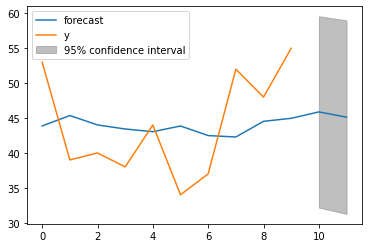

In [56]:
# plot the confidence intervals for an ARIMA forecast
# load data
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# split into train and test sets
X = series.values
X = X.astype('float32')
size = len(X) - 1
train, test = X[0:size], X[size:]
# fit an ARIMA model
model = ARIMA(train, order=(5,1,1))
model_fit = model.fit()
# plot some history and the forecast with confidence intervals
model_fit.plot_predict(len(train)-10, len(train)+1)
pyplot.legend(loc='upper left')
pyplot.show()